# Enhanced protein isoform characterization through long-read proteogenomics 
## Supplementary Figure 5
---
Ben Jordan | Gloria Sheynkman

In [1]:
import pandas as pd 
import numpy as np
import os
import seaborn as sns 
from scipy import stats
import matplotlib.pyplot as plt
import os, sys
import matplotlib
from matplotlib import colors


import config, data_loader

matplotlib.rc('font', **config.font)

# all plots go into a directory
if not os.path.exists('plot'):
    os.makedirs('plot')

# all statistics go into a directory
if not os.path.exists('stats'):
    os.makedirs('stats')

#### Supp Fig5: Long-read-informed protein isoform detection. 


In [2]:
# file paths
filtered_protein_file = f'{config.PIPELINE_RESULTS_DIRECTORY}/protein_filter/{config.EXPERIMENT_NAME}.classification_filtered.tsv' # filtered protein file
peptide_file = f'{config.PIPELINE_RESULTS_DIRECTORY}/metamorpheus/pacbio/hybrid/search_results/Task1SearchTask/AllPeptides.{config.EXPERIMENT_NAME}.hybrid.psmtsv' # peptide file
# #read in files
filtered_orf = pd.read_table(filtered_protein_file)
# filtered_orf['pb'] = filtered_orf['base_acc']
filtered_orf['gene'] = filtered_orf['pr_gene']
filtered_orf = filtered_orf[filtered_orf['pb'].isin(data_loader.accs_in_hiconf_space)]

filtered_orf = filtered_orf[['pb', 'gene', 'CPM']]

# filtered_orf = filtered_orf[filtered_orf]
peptides = pd.read_table(peptide_file)
peptides = peptides[(peptides['Decoy/Contaminant/Target'] == 'T') & (peptides['QValue'] <= 0.01)]
peptides = peptides[['Protein Accession', 'Full Sequence', 'PSM Count (unambiguous, <0.01 q-value)']]
peptides = peptides.rename(columns = {'PSM Count (unambiguous, <0.01 q-value)':'PSM'})
peptides['Protein Accession'] = peptides['Protein Accession'].str.split('|')
peptides = peptides.explode('Protein Accession')
# peptides = peptides[peptides['Protein Accession'].str.startswith('PB.')]

# plot correlation of peptide PSM vs CPM group by gene
# note - each line is a peptide value, below
combined = pd.merge(filtered_orf, peptides, how = 'left', right_on = 'Protein Accession', left_on = 'pb')
gene_grouped = combined.groupby('gene').sum()
gene_grouped['log2(PSM+1)'] = np.log2(gene_grouped['PSM'] + 1 )
gene_grouped['log2(CPM+1)'] = np.log2(gene_grouped['CPM'] + 1)

### Supp Fig 5a, Correlation between long-read transcriptional abundance and protein abundance. Results are grouped by gene.

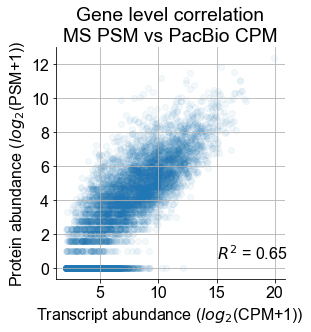

In [3]:


slope, intercept, r_value, p_value, std_err = stats.linregress(gene_grouped['log2(CPM+1)'],gene_grouped['log2(PSM+1)'])
sns.lmplot(data=gene_grouped, x = 'log2(CPM+1)', y = 'log2(PSM+1)', scatter_kws={'alpha':0.05},fit_reg=False, height=4) 
plt.rc('axes', axisbelow=True)
plt.grid()
plt.xlabel('Transcript abundance ($log_2$(CPM+1))')
plt.ylabel('Protein abundance ($log_2$(PSM+1))')
plt.title('Gene level correlation\nMS PSM vs PacBio CPM')
plt.text(15, 0.5, '$R^2$ = %0.2f' % r_value**2)
plt.savefig(f'plot/SuppFig5a_correlation_gene_level_psm_cpm_hybrid.png', dpi=300, bbox_inches='tight')
# plt.axvline(x=np.log2(25+1), color='red')
# plt.savefig(f'plot/Fig6b_correlation_gene_level_psm_cpm_with_vline.png', dpi=300, bbox_inches='tight')



### Supp Fig 5b, Fraction of genes detected by MS as a function of transcript abundance.

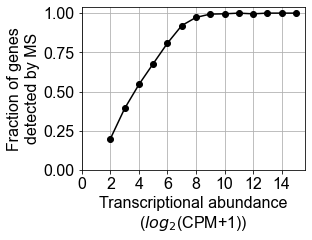

In [4]:
# output source data
gene_grouped2 = (gene_grouped
                    .assign(ms_detected=lambda x: x['PSM']>0)
                    .reset_index()
                    .filter(items=['gene', 'CPM', 'log2(CPM+1)', 'ms_detected'])
                    .set_axis(['gene', 'cpm', 'log2(cpm+1)', 'ms_detected'], axis=1))
# plot cumulative probability of genes detected via ms
# for cpm ranges, determine the fraction of genes for which protein(s) were detected
data = [] # [[cpm_threshold, number_genes_detected, total_genes_in_bin, frac_detected]] 
gene_det = (gene_grouped2
                .sort_values(by=['log2(cpm+1)']))
max_x_value = 16 # max log2cpm
for cpm_thresh in range(2, max_x_value): 
    subset = gene_det[(gene_det['log2(cpm+1)']>cpm_thresh) & (gene_det['log2(cpm+1)']<=(cpm_thresh+1))]
    total = subset.shape[0]
    num_detected = subset[subset['ms_detected']==True].shape[0]
    frac_detected = num_detected / total
    data.append([cpm_thresh, num_detected, total, frac_detected])
frac_det = pd.DataFrame(data, columns=['cpm_thresh', 'num_genes_w_ms_detection', 'total_num_genes', 'prot_detect_frac'])
# make plot
fig, ax = plt.subplots(figsize=(4,3))
ax.grid()
ax.scatter(frac_det.cpm_thresh, frac_det.prot_detect_frac, color='black')
ax.plot(frac_det.cpm_thresh, frac_det.prot_detect_frac, color='black')
ax.set_xlabel('Transcriptional abundance\n($log_2$(CPM+1))')
ax.set_xticks(range(0,16,2))
ax.set_ylim(0)
ax.set_ylabel('Fraction of genes\ndetected by MS')
plt.savefig('plot/SuppFig5b_frac_gene_detect_at_diff_cpm_threshold_hybrid.pdf', bbox_inches='tight')
# plt.axvline(x=np.log2(25+1), color='red')
# plt.savefig('plot/Fig6c_frac_gene_detect_at_diff_cpm_threshold_with_cpm_vline.pdf', bbox_inches='tight')

# output source data
def make_cpm_bin_string_for_output(row):
    cpm_thresh = int(row['cpm_thresh'])
    cpm_bin = '(' + str(cpm_thresh) + '-' + str(cpm_thresh+1) + ']'
    return cpm_bin
frac_det['cpm_bin'] = frac_det.apply(make_cpm_bin_string_for_output, axis=1)
(frac_det
    .set_axis(['cpm_thresh', 'num_genes_ms_detect', 'num_genes_all', 'ms_detect_frac', 'log2(cpm+1)_range'], axis=1)
    .drop(columns=['cpm_thresh'])
    .loc[:, ['log2(cpm+1)_range', 'num_genes_ms_detect', 'num_genes_all', 'ms_detect_frac']]
    .to_csv('stats/SuppFig5b_frac_gene_detect_at_diff_cpm_threshold_hybrid.tsv', sep='\t', index=None))




### Supp Fig 5c. Distribution of the fractional relative abundance of the most abundant protein isoform in each indistinguishable protein group.

higher than 0.9: 1434
between 0.4 and 0.6: 268
2 or more isoforms both expressed at 0.3 or higher: 301


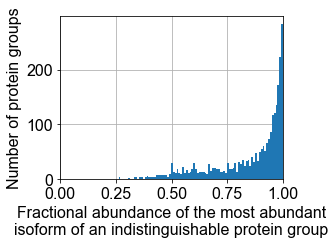

In [7]:
# df = pd.read_excel('./AmbigProteinGroups_RR_HC.xlsx')
df = pd.read_excel('./AmbigProteinGroups_RR_HC_update.xlsx')



def get_highest_fraction(row):
	rel_abunds = row['Relative ORF abundance']
	abunds = [float(x) for x in rel_abunds.split('|')]
	highest_frac = max(abunds)
	return(highest_frac)
df['highest_frac'] = df.apply(get_highest_fraction, axis=1)


def find_coexpr_isoforms(row):
	rel_abunds = row['Relative ORF abundance']
	abunds = [float(x) for x in rel_abunds.split('|') if float(x) >= 0.3]
	if len(abunds) >= 2:
		return 1
	else:
		return 0
df['coexpr'] = df.apply(find_coexpr_isoforms, axis=1)

fig, ax = plt.subplots(figsize=(4,3))
ax.hist(df['highest_frac'], bins=100, zorder=4)
plt.xlabel('Fractional abundance of the most abundant\nisoform of an indistinguishable protein group')
plt.ylabel('Number of protein groups')
plt.grid(zorder=0)
plt.xlim(0,1)
plt.savefig('plot/SuppFig5c.png', dpi=400, bbox_inches='tight')

print('higher than 0.9:', df[df['highest_frac']>0.9].shape[0])
print('between 0.4 and 0.6:', df[(df['highest_frac']>0.4) & (df['highest_frac']<0.6)].shape[0])
print('2 or more isoforms both expressed at 0.3 or higher:', sum(df['coexpr']))
